<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> Business Problem </h1>

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h1> Machine Learning Probelm </h1>

<h3> Data Overview </h3>
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

In [2]:
class myClass:
    def get_s3_object(self,bucket,key):
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(io.BytesIO(obj['Body'].read()))
        return df
    
    def upload_to_s3(self,bucket,key,file_path):
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file(file_path)

awsObjects = myClass()

In [3]:
role = get_execution_role()

In [4]:
bucket = 'ars-mlops-projects'
key = 'Quora/data/train.csv'
df = awsObjects.get_s3_object(bucket,key)


In [5]:
pd.__version__

'1.3.5'

In [6]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

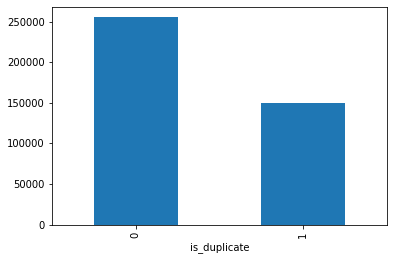

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


## Number of Unique Question

In [12]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of uniqe question are {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of uniqe question are 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



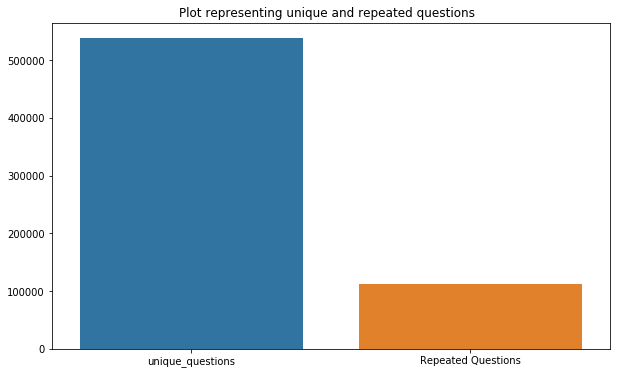

In [13]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [14]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate questions",(pair_duplicates).shape[0]-df.shape[0])

Number of duplicate questions 0


## Number of occurances of each question

Number of time a single question is repeated : 157


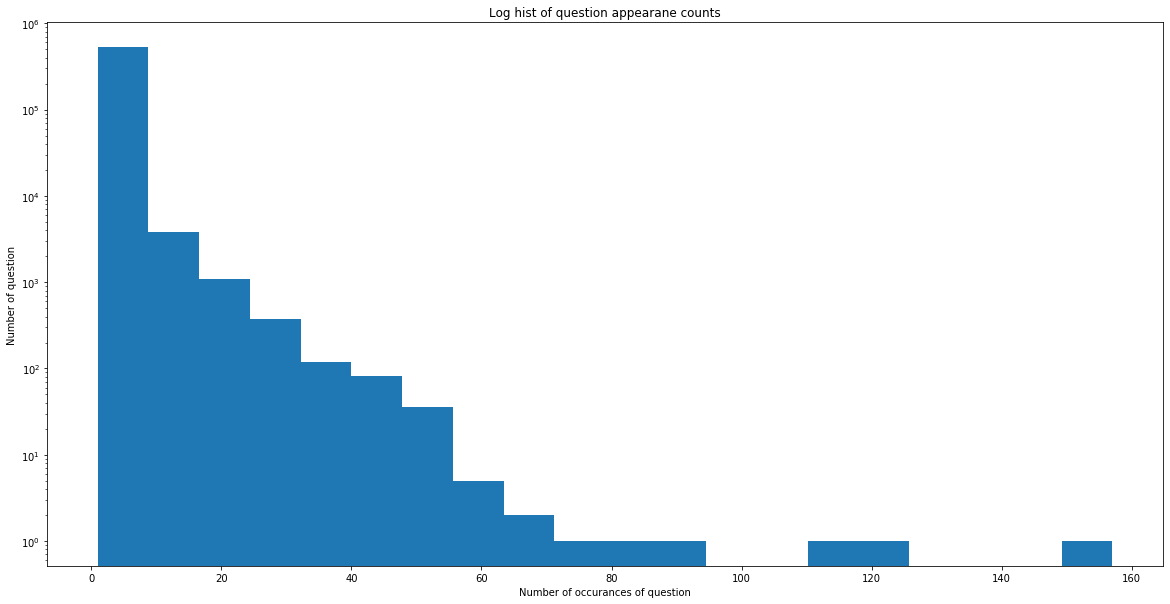

In [15]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=20)
plt.yscale('log',nonposy='clip')
plt.title('Log hist of question appearane counts')
plt.xlabel('Number of occurances of question')
plt.ylabel('Number of question')
print('Number of time a single question is repeated : {}'.format(max(qids.value_counts())))

In [17]:
nan_rows = df[df.isnull().any(1)]
len(nan_rows)

3

In [19]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Basic Feature Extraction

In [22]:
if os.path.isfile('data/df_fe_without_preprocessing_train.csv'):
    df=pd.read_csv("data/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_common(row):
        w1 =set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
        w2 =set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_common,axis=1)
    
    def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_total,axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    
    df['word_share'] = df.apply(normalized_word_share,axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-q2'] = df['freq_qid1'] - df['freq_qid2']
    
    df.to_csv("data/df_fe_without_preprocessing_train.csv",index=False)
    
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


## Analysis of extracted features

In [24]:
print("Minimum length of the questions in question1 : ", min(df['q1_n_words']))
print("Minimum length of the questions in question1 : ", min(df['q2_n_words']))


Minimum length of the questions in question1 :  1
Minimum length of the questions in question1 :  1


In [27]:
print("Number of Question with minimum length question1:",df[df['q1_n_words']==1].shape[0])
print("Number of Question with minimum length question2:",df[df['q2_n_words']==1].shape[0])

Number of Question with minimum length question1: 67
Number of Question with minimum length question2: 24


### Feature Word Share

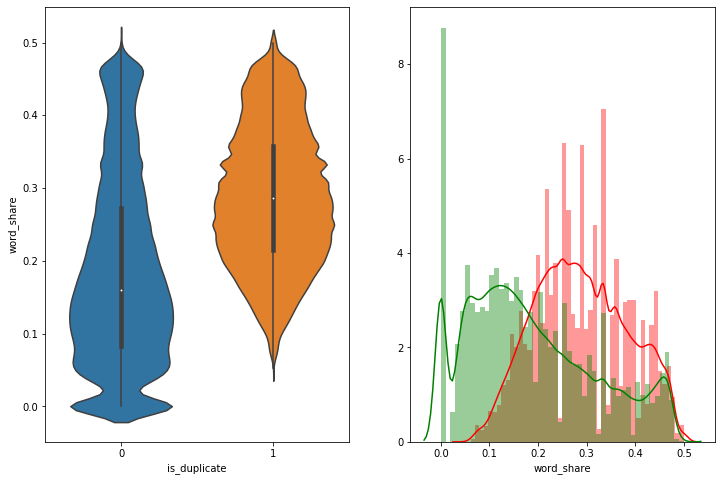

In [31]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:],label="1",color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:],label="1",color='green')


- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

### Feature: word_common

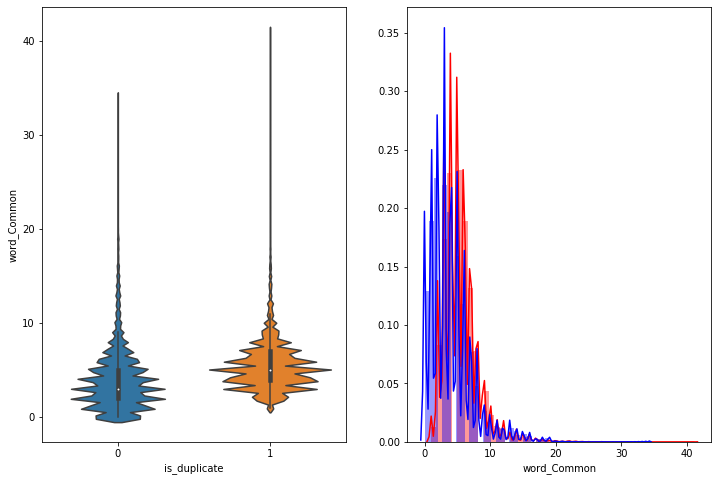

In [34]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'] ,label="1",color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'], label="0",color='blue')

In [40]:
awsObjects.upload_to_s3(bucket,'Quora/data/df_fe_without_preprocessing_train.csv','data/df_fe_without_preprocessing_train.csv')

__End of Feature Engineeting__